# Semantic Segmentation with ResNetUNet

This Kaggle notebook explores semantic segmentation using a ResNetUNet architecture. Semantic segmentation involves classifying each pixel in an image to a specific category, providing a detailed understanding of the image's content. In this notebook, we focus on flood area segmentation as an application.

## Dataset
The dataset consists of images and corresponding masks representing flood areas. The images and masks are loaded using a custom dataset class, and transformations are applied for preprocessing.

## Model Architecture
The semantic segmentation model is built using a ResNetUNet architecture, combining the power of ResNet as a backbone with the segmentation capabilities of UNet. The model is trained with a Dice Loss and Adam optimizer.

The classical U-Net architecture is shown below. In this architecture, the encoder has been replaced by a pretrained ResNet encoder.

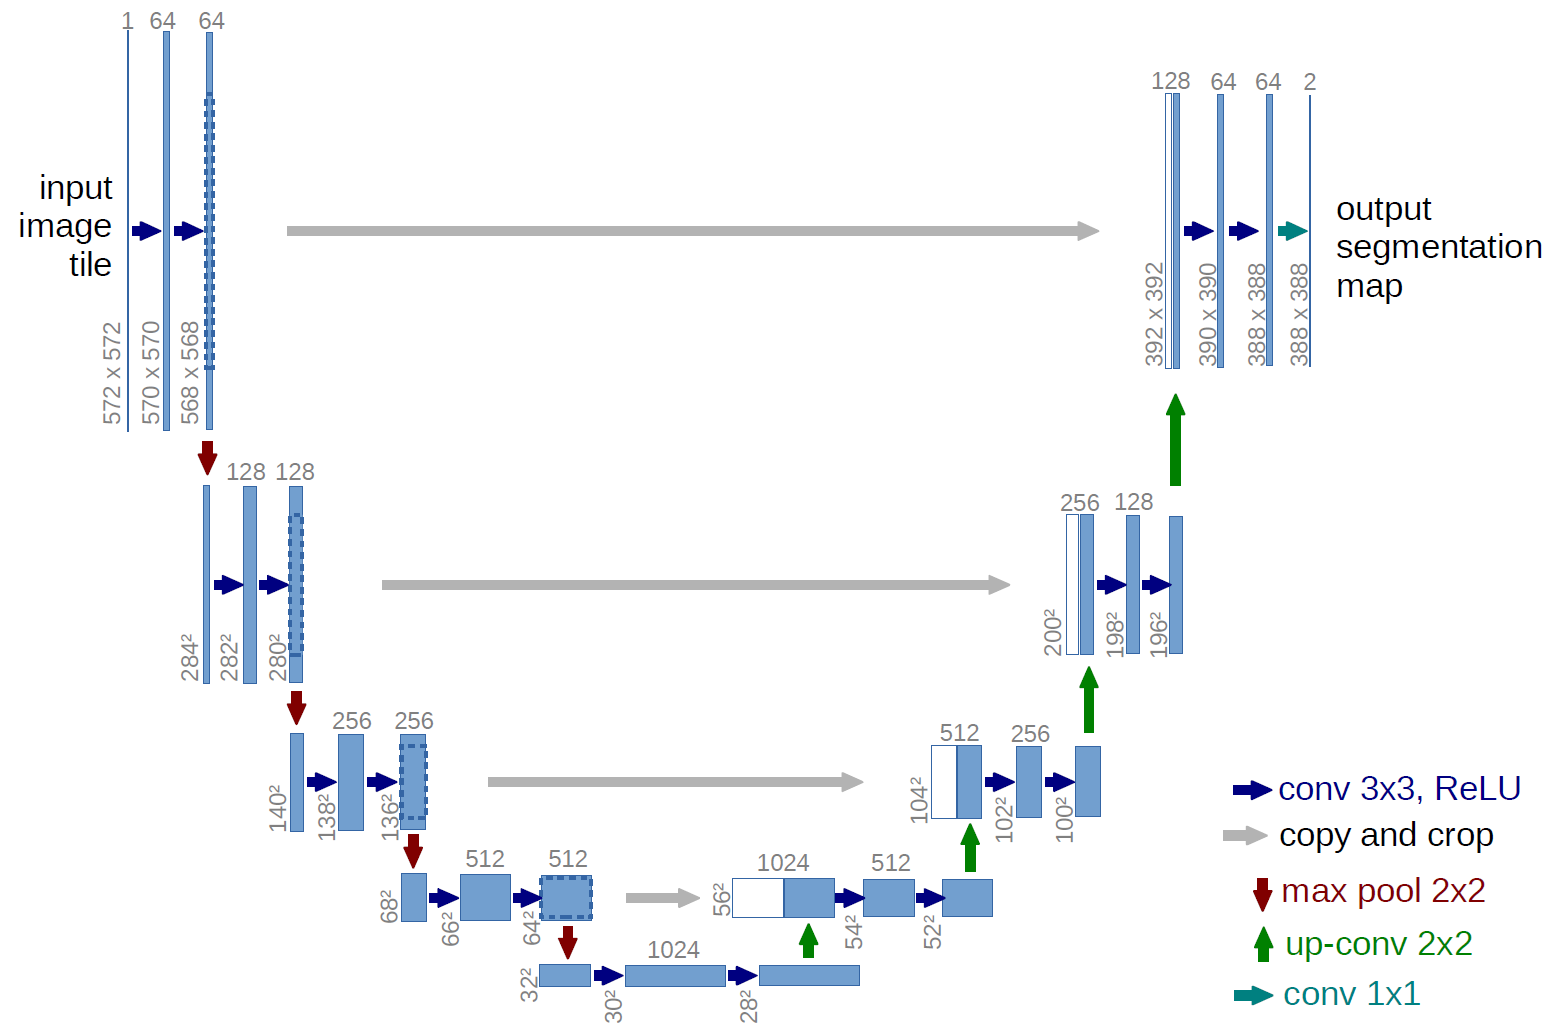


## Training and Evaluation
The notebook includes functions for training the model, visualization of training samples, and evaluation metrics computation. Early stopping is employed to prevent overfitting.

## Results
The trained model is loaded, and examples from the validation and test sets are visualized. Metrics such as accuracy, IoU, F1 score, precision, and recall are computed for assessing the model's performance.

Feel free to explore the code cells for a detailed walkthrough of the implementation and insights into semantic segmentation with ResNetUNet.


## Import necessary libraries for image processing, deep learning, and visualization

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Subset, random_split

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Typing
from typing import Any, Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [2]:
main_directory_path = 'D:\\Technion\\ProjectDeepLearning\\Eyal1\\FloodAreaSegmentation'

import sys
import os
sys.path.append(main_directory_path)

from scripts.utils import get_processed_images_and_masks, get_augmented_images_and_masks


Processed images: ['../data/raw/images\\0.jpg', '../data/raw/images\\1.jpg', '../data/raw/images\\2.jpg', '../data/raw/images\\3.jpg', '../data/raw/images\\4.jpg', '../data/raw/images\\5.jpg', '../data/raw/images\\6.jpg', '../data/raw/images\\7.jpg', '../data/raw/images\\8.jpg', '../data/raw/images\\9.jpg', '../data/raw/images\\10.jpg', '../data/raw/images\\11.jpg', '../data/raw/images\\12.jpg', '../data/raw/images\\13.jpg', '../data/raw/images\\14.jpg', '../data/raw/images\\15.jpg', '../data/raw/images\\16.jpg', '../data/raw/images\\17.jpg', '../data/raw/images\\18.jpg', '../data/raw/images\\19.jpg', '../data/raw/images\\20.jpg', '../data/raw/images\\21.jpg', '../data/raw/images\\22.jpg', '../data/raw/images\\23.jpg', '../data/raw/images\\24.jpg', '../data/raw/images\\25.jpg', '../data/raw/images\\26.jpg', '../data/raw/images\\27.jpg', '../data/raw/images\\28.jpg', '../data/raw/images\\29.jpg', '../data/raw/images\\30.jpg', '../data/raw/images\\31.jpg', '../data/raw/images\\32.jpg', '

In [3]:
torch.cuda.empty_cache()

## Define Constants and Seed

In [4]:
# IMAGE_DIR = "archive/Image/"
# MASK_DIR = "archive/Mask/"

BATCH_SIZE = 8//2            # small to avoid vague faces/backgrounds
PATCH_SIZE = (512, 512)   # size of the patches

TENSOR_BOARD_BASE   = 'TB'

torch.manual_seed(42)     # Set a global random seed for reproducibility

## Define Custom Dataset Class

In [5]:
class FloodAreaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None, augmentations=None):
        self.img_labels = sorted([file for file in os.listdir(image_dir)])
        self.img_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        mask_path = os.path.join(self.mask_dir, self.img_labels[idx]).replace(".jpg", ".png")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augmentations:
            image, mask = self.augmentations(image, mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask.long()

## Define Image and Mask Transformations

In [6]:
image_transform = transforms.Compose([
    transforms.Resize(size=PATCH_SIZE, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=PATCH_SIZE, antialias=False)
])

# train_augmentations = transforms.Compose([
#     transforms.RandomVerticalFlip(),
# ])

In [7]:
processed_images, processed_masks = get_processed_images_and_masks()
IMAGE_DIR = os.path.dirname(processed_images[0])
MASK_DIR = os.path.dirname(processed_masks[0])

print(IMAGE_DIR, MASK_DIR)

../data/raw/images ../data/raw/masks


## Create Dataset and DataLoader Instances

In [8]:
# Define the dataset
dataset = FloodAreaDataset(IMAGE_DIR, MASK_DIR, image_transform=image_transform, mask_transform=mask_transform)
print(dataset)

# test_size = int(0.15 * dataset_size)
# val_size  = int(0.15 * dataset_size)
# train_size = dataset_size - test_size - val_size
# mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = test_size, train_size = train_size, shuffle = True, stratify = vY)

# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))
print(train_dataset[0][0].shape)
# train_dataset.augmentations = train_augmentations

# Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([3, 512, 512])


## Define Functions for Denormalization and Visualization

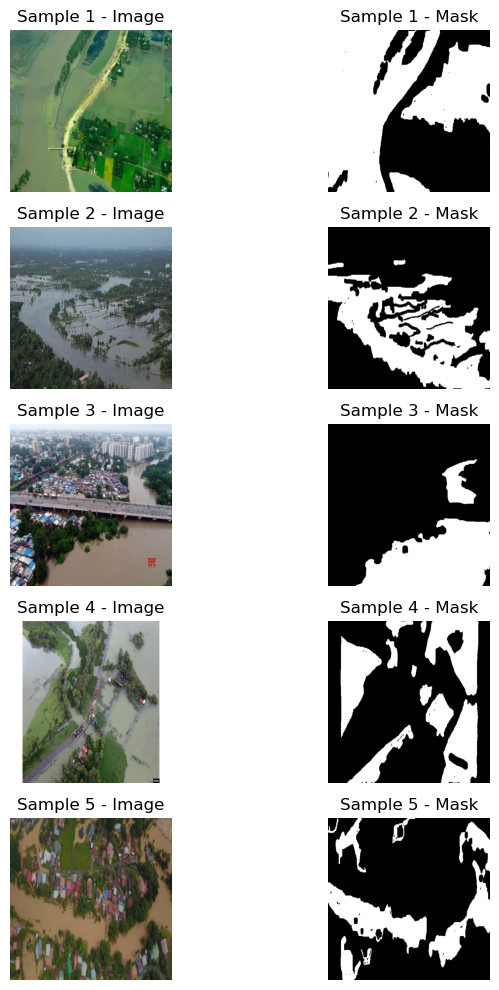

In [9]:
# Function to denormalize images
def denormalize_tensor(image, mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Function to visualize images and masks
def visualize_samples(dataset, num_samples=5):
    # Visualize the images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        
        # Display images
        axes[i, 0].imshow(denormalize_tensor(image).cpu().permute(1,2,0))
        axes[i, 0].set_title(f'Sample {i + 1} - Image')
        axes[i, 0].axis('off')

        # Display masks
        axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Sample {i + 1} - Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset)

## Define UNet Components (Up, DoubleConv, OutConv)

In [10]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)    

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UpResNet(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, out_channels, bilinear=True, dropout_rate=0.1):
        super(UpResNet, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels_1, in_channels_1, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels_1 + in_channels_2, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    

## Define ResNetUNet Model

In [11]:
class ResNetUNet(nn.Module):
    def __init__(self, in_channels, out_channels, resnet_type="resnet18", bilinear=False, dropout_rate = 0.1):
        super(ResNetUNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resnet_type = resnet_type
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate
        
        # Define the backbone network
        if self.resnet_type == "resnet18":
            self.backbone_model = torchvision.models.resnet18(weights="DEFAULT")
            self.channel_distribution = [3, 64, 64, 128, 256]
        elif self.resnet_type == "resnet34":
            self.channel_distribution = [3, 64, 64, 128, 256]
            self.backbone_model = torchvision.models.resnet34(weights="DEFAULT")
        elif self.resnet_type == "resnet50":
            self.channel_distribution = [3, 64, 256, 512, 1024]
            self.backbone_model = torchvision.models.resnet50(weights="DEFAULT")
        else:
            print("Resnet type is not recognized. Loading ResNet 18 as backbone model")
            self.channel_distribution = [3, 64, 64, 128, 256]
            self.backbone_model = torchvision.models.resnet34(weights="DEFAULT")
        
        self.backbone_layers = list(self.backbone_model.children())
        
        # Define the ResNetUNet
        self.inc = DoubleConv(in_channels, 64)
        
        self.block1 = nn.Sequential(*self.backbone_layers[0:3])
        self.block2 = nn.Sequential(*self.backbone_layers[3:5])
        self.block3 = nn.Sequential(*self.backbone_layers[5])
        self.block4 = nn.Sequential(*self.backbone_layers[6])
        
        self.up1 = Up(self.channel_distribution[-1], self.channel_distribution[-2], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up2 = Up(self.channel_distribution[-2], self.channel_distribution[-3], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up3 = UpResNet(self.channel_distribution[-3], 64, self.channel_distribution[-4], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up4 = UpResNet(self.channel_distribution[-4], 64, self.channel_distribution[-4], bilinear=bilinear, dropout_rate = dropout_rate)
        
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)

#         print("x0: ", x0.shape)
#         print("x1: ", x1.shape)
#         print("x2: ", x2.shape)
#         print("x3: ", x3.shape)
#         print("x4: ", x4.shape)

        y1 = self.up1(x4, x3)
        y2 = self.up2(x3, x2)
        y3 = self.up3(x2, x1)
        y4 = self.up4(x1, x0)

        logits = self.outc(y4)
        
        return logits

## Instantiate Model and Freeze Parameters

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet_unet = ResNetUNet(in_channels=3, out_channels=2, resnet_type="resnet34").to(device)

# Freeze parameters in blocks 1, 2, 3, and 4
for block in [resnet_unet.block1, resnet_unet.block2, resnet_unet.block3, resnet_unet.block4]:
    for param in block.parameters():
        param.requires_grad_(False)

## Define Training Constants and Initialize Early Stopping Parameters

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = 20

# Define the loss function, optimizer, and learning rate scheduler
criterion = smp.losses.DiceLoss('multiclass')
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

d:\Technion\envs\FloodSegProg\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
torchinfo.summary(resnet_unet)

Layer (type:depth-idx)                        Param #
ResNetUNet                                    --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    │    └─BasicBlock: 3-3                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   (230,144)
│    │    └─BasicBlock: 3-5                   (295,424)
│    │    └─BasicBlock: 3-6                   (295,424)
│    │    └─BasicBlock: 3-7                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   (919,040)
│    │    └─BasicBlock: 3-9                   (1,180

## Train the model

In [15]:
# Define the Writer
example_input = torch.randn(BATCH_SIZE, 3, 512, 512)  # Modify this based on your model's input requirements
print(example_input.shape)

# Move the example input to the same device as the model
device = next(resnet_unet.parameters()).device
example_input = example_input.to(device)

oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'unet_resnet_graph'))
oTBWriter.add_graph(resnet_unet, example_input) #<! Graph of the Model
oTBWriter.close()

torch.Size([4, 3, 512, 512])


In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4, oTBWriter = None):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []
    
    global_step_train = 0
    global_step_val = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Log train loss at each batch
            global_step_train += 1
            if oTBWriter is not None:
                oTBWriter.add_scalar('Train Loss', loss.item(), global_step_train)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.inference_mode():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Log validation loss at each batch
                global_step_val += 1
                if oTBWriter is not None:
                    oTBWriter.add_scalar('Validation Loss', loss.item(), global_step_val)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        #!!!
        if oTBWriter is not None:
            oTBWriter.add_scalar('Train Loss Epochs', avg_train_loss, epoch)
            oTBWriter.add_scalar('Validation Loss Epochs', avg_val_loss, epoch)
        #!!!

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model_resnetUnet.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, 'resnet_unet'))
train_model(resnet_unet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, early_stop_patience=7, oTBWriter=oTBWriter)
oTBWriter.close()

# Load the best model after training
resnet_unet.load_state_dict(torch.load('best_model_resnetUnet.pth'))

Epoch [1/50], Train Loss: 0.2512, Validation Loss: 0.1934
Epoch [2/50], Train Loss: 0.2063, Validation Loss: 0.1790
Epoch [3/50], Train Loss: 0.2043, Validation Loss: 0.1833
Epoch [4/50], Train Loss: 0.1994, Validation Loss: 0.1726
Epoch [5/50], Train Loss: 0.1982, Validation Loss: 0.1907
Epoch [6/50], Train Loss: 0.1922, Validation Loss: 0.2115
Epoch [7/50], Train Loss: 0.1955, Validation Loss: 0.1927
Epoch [8/50], Train Loss: 0.1883, Validation Loss: 0.1801
Epoch [9/50], Train Loss: 0.1803, Validation Loss: 0.1938
Epoch [10/50], Train Loss: 0.1849, Validation Loss: 0.1773
Epoch [11/50], Train Loss: 0.1872, Validation Loss: 0.1762
Early stopping after 7 epochs without improvement.


<All keys matched successfully>

## Plot Examples from Test Dataset

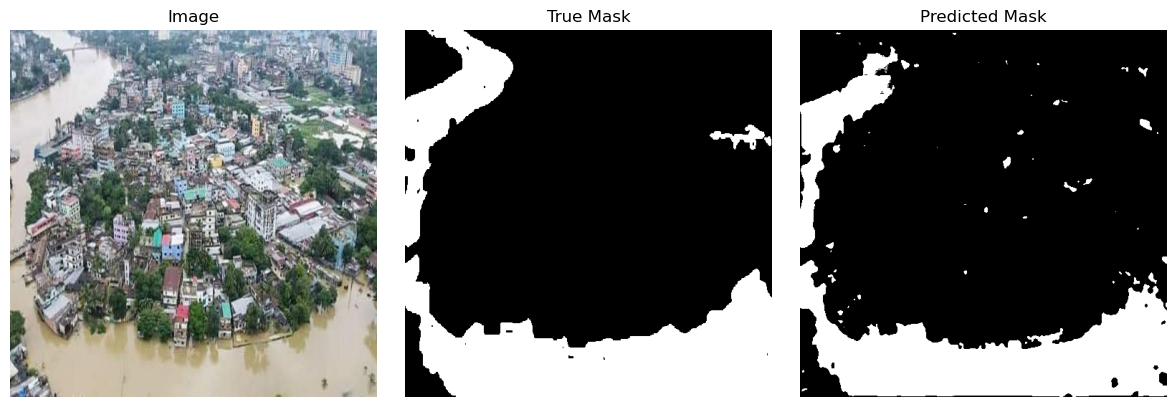

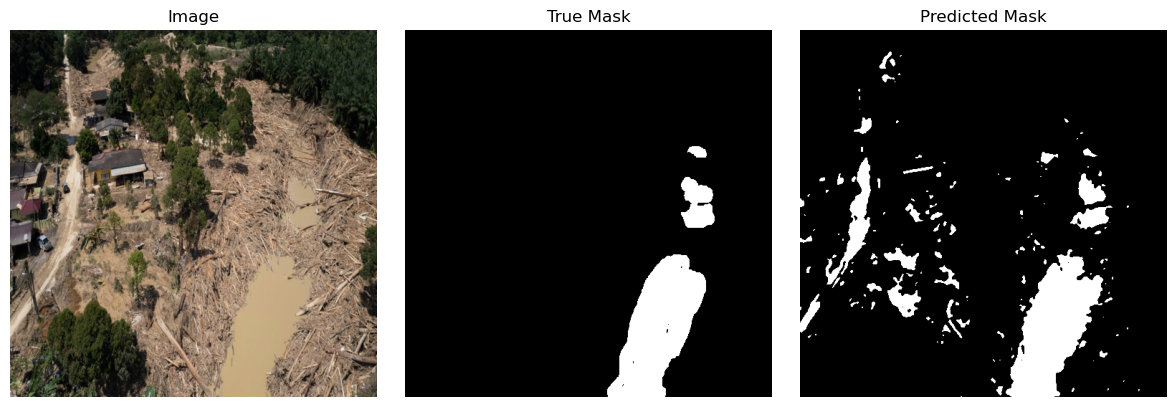

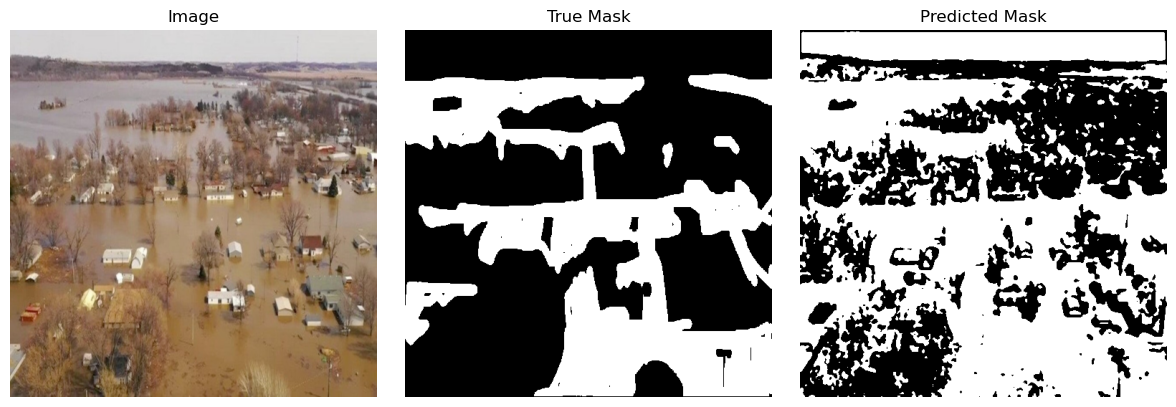

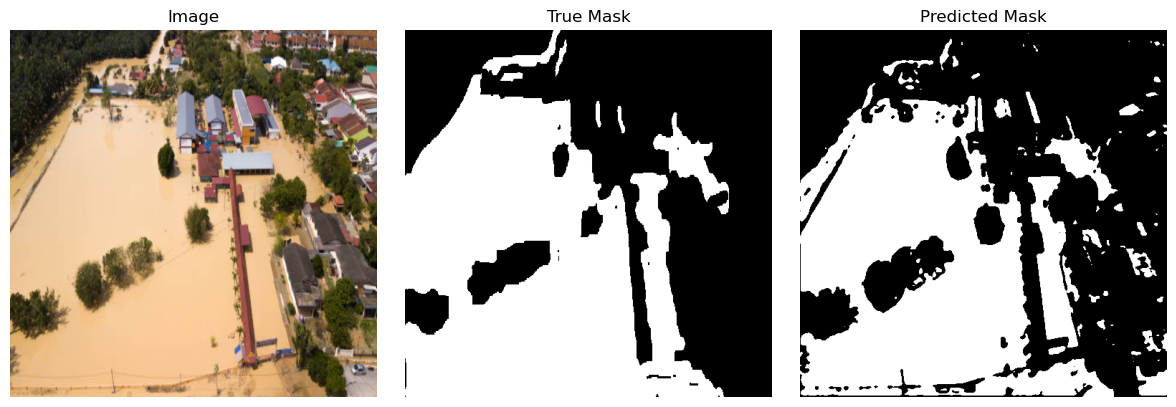

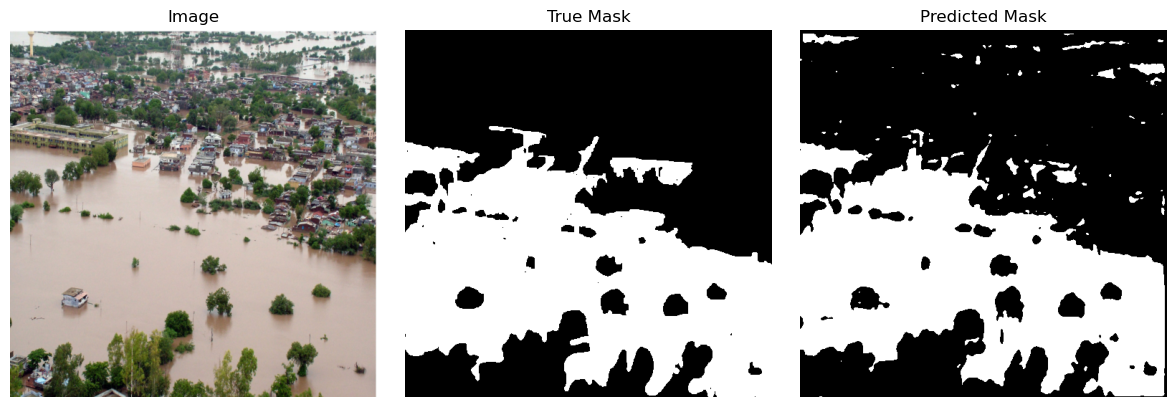

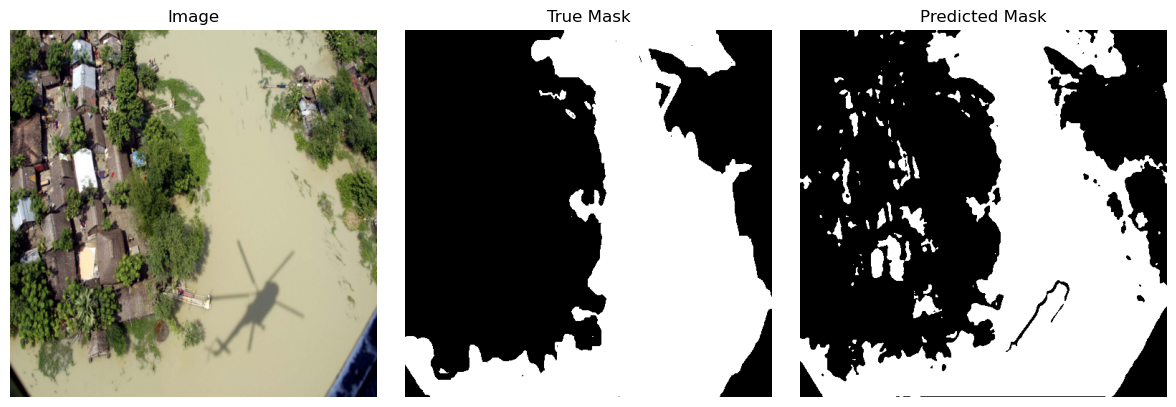

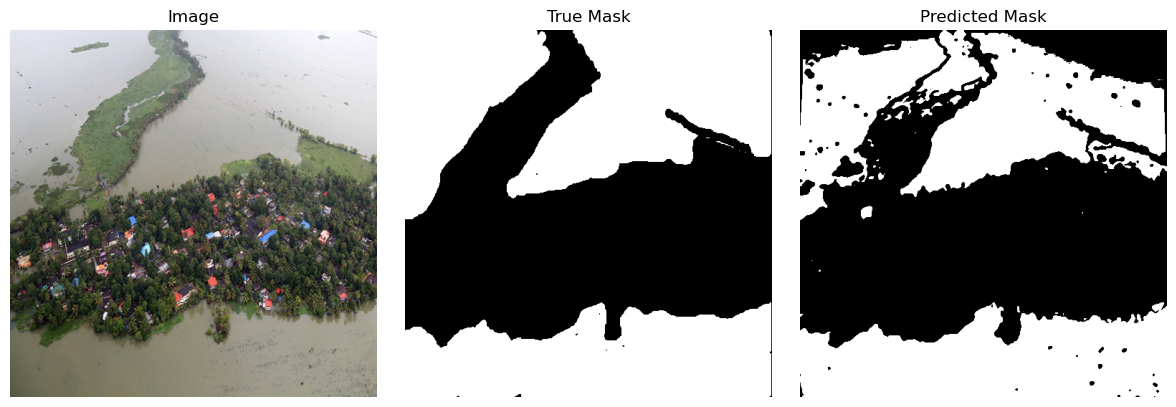

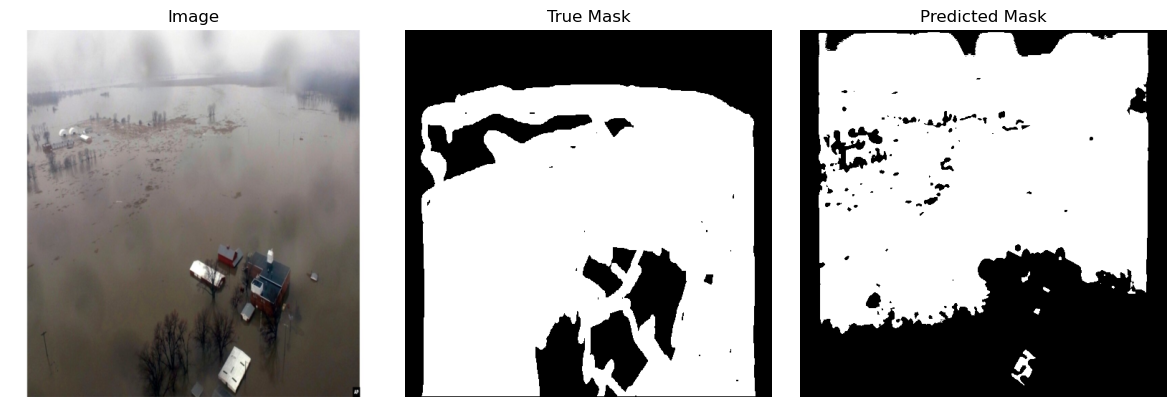

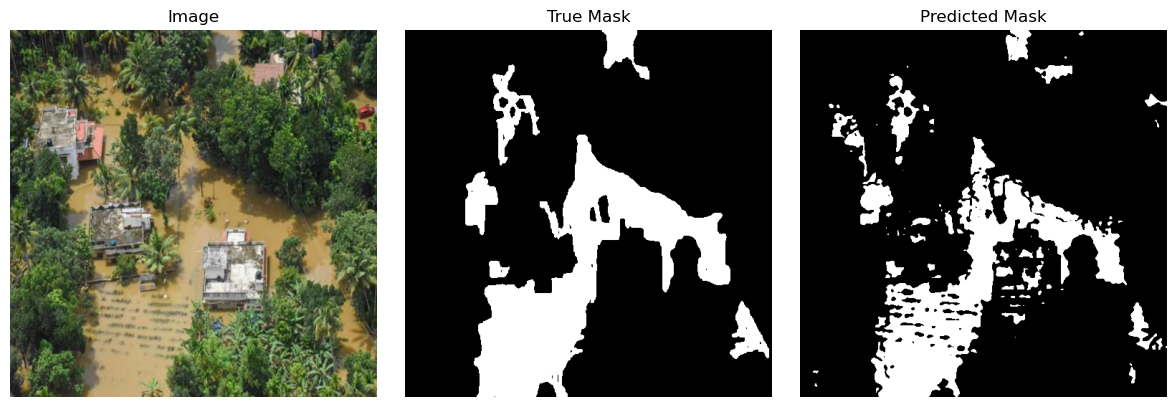

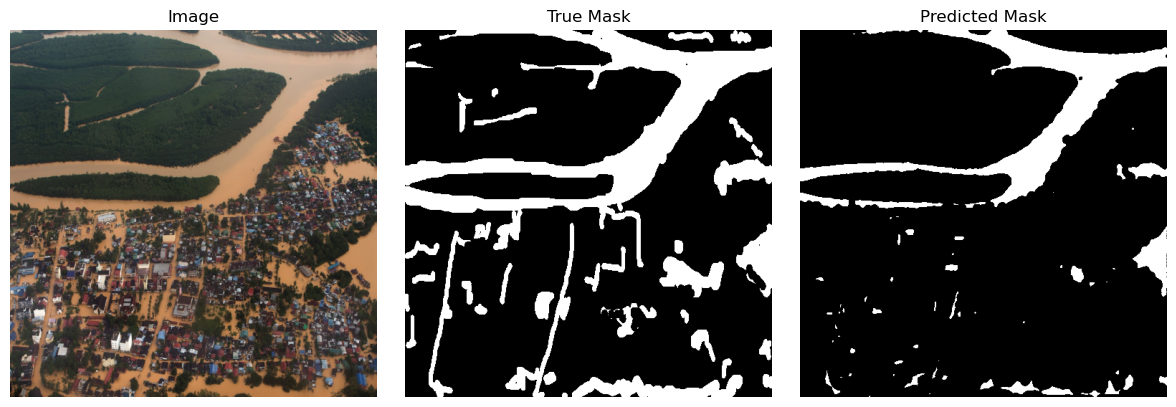

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.inference_mode():
            output = model(image.unsqueeze(0).to(device)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(denormalize_tensor(image).permute(1,2,0))
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Plot examples from the test dataloader
plot_examples(resnet_unet, test_dataset, num_examples=10)


## Compute metrics for test, train and validation datasets

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(device), masks.to(device)
        
        with torch.inference_mode():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy()
        pred_masks_np = pred_masks.cpu().detach().numpy()
        
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(pred_masks_np)
    
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)
    
    # Flatten masks for binary classification
    all_true_masks_flat = all_true_masks.flatten()
    all_pred_masks_flat = all_pred_masks.flatten()

    # Calculate and print metrics
    accuracy  = accuracy_score(all_true_masks_flat, all_pred_masks_flat)
    jaccard   = jaccard_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    f1        = f1_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    precision = precision_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    recall    = recall_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Compute metrics for training set
print("Metrics for Training Set:")
compute_metrics(resnet_unet, train_loader)

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(resnet_unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(resnet_unet, test_loader)


Metrics for Training Set:


100%|██████████| 51/51 [00:10<00:00,  5.03it/s]


  Accuracy : 0.8398
  IoU      : 0.7235
  F1 Score : 0.8380
  Precision: 0.8393
  Recall   : 0.8398

Metrics for Validation Set:


100%|██████████| 11/11 [00:02<00:00,  4.82it/s]


  Accuracy : 0.8464
  IoU      : 0.7340
  F1 Score : 0.8451
  Precision: 0.8454
  Recall   : 0.8464

Metrics for Test Set:


100%|██████████| 11/11 [00:02<00:00,  4.74it/s]


  Accuracy : 0.8338
  IoU      : 0.7148
  F1 Score : 0.8323
  Precision: 0.8332
  Recall   : 0.8338
